In [1]:
# %matplotlib notebook

In [2]:
# %matplotlib qt

In [3]:
from __future__ import annotations

import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (нужно для 3D)

from maneuvering.types import Scalar
from maneuvering.orbit.keplerian import Kep, KepTrue
from maneuvering.orbit.distance import distance_orbit
from maneuvering.maneuvers.quasi_circular.reference_orbit import trans_devs, reference_orbit
from maneuvering.maneuvers.quasi_circular.transition.coplanar import coplanar_non_intersecting, coplanar_analytical
from maneuvering.maneuvers.quasi_circular.transition.execute import execute, execute_batch
from maneuvering.utils.math_tools import normalize_angle
from maneuvering.maneuvers.maneuver import Maneuver

In [4]:
deg = math.pi / 180.0
mu = 3.9860044158e14

### Зависимость хар. скорости от начального угла для случая непересекающихся орбит

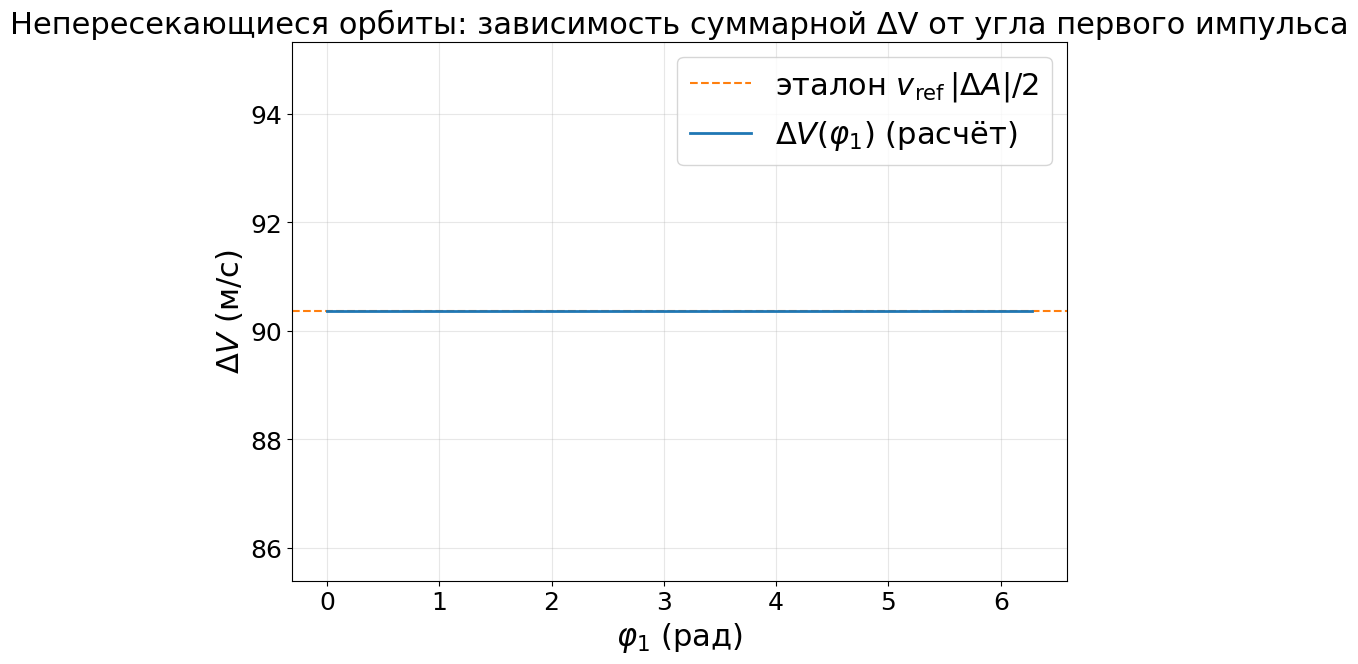

In [5]:
oi = Kep(a=6_566_000.0, e=0.00228, w=20 * deg, i=0.0, raan=130 * deg)
ot = Kep(a=6_721_000.0, e=0.00149, w=150 * deg, i=0.0, raan=130 * deg)

# Параметры задачи перехода
devs = trans_devs(oi, ot)
ref = reference_orbit(oi, ot, mu)  # ref.v — круговая скорость на опорной орбите

# Сканируем угол первого импульса: ang1 ∈ [0, 2π)
thetas = np.linspace(0.0, 2.0 * np.pi, 720, endpoint=False)
dV = np.empty_like(thetas)

for k, ang1 in enumerate(thetas):
    try:
        mans = coplanar_non_intersecting(devs, ang1=ang1)  # dv безразмерные (по v_ref)
        # в непересекающемся случае импульсы чисто трансверсальные: берём y-компоненту
        dvt_sum_abs = abs(mans[0].dv[1]) + abs(mans[1].dv[1])
        dV[k] = ref.v * dvt_sum_abs
    except ZeroDivisionError:
        dV[k] = np.nan  # теоретически, когда знаменатель в формуле обнуляется

# Эталон: ΔV = v_ref * |ΔA| / 2 (не зависит от угла)
dV_ref = ref.v * abs(devs.a) / 2.0

# График
fig, ax = plt.subplots(figsize=(10, 7))
ax.axhline(dV_ref, ls='--', color='C1', label=r'эталон $v_{\rm ref}\,|\Delta A|/2$')
ax.plot(thetas, dV, lw=2, color='C0', label=r'$\Delta V(\varphi_1)$ (расчёт)')

ax.set_xlabel(r'$\varphi_1$ (рад)', fontsize=22)  # угол первого импульса
ax.set_ylabel(r'$\Delta V$ (м/с)', fontsize=22)
ax.set_title('Непересекающиеся орбиты: зависимость суммарной ΔV от угла первого импульса', fontsize=22)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=22)
plt.show()

### Годограф базис-вектора

In [6]:
def primer_coeffs(m1: Maneuver, m2: Maneuver) -> tuple[Scalar, Scalar, Scalar]:
    """
    Вычисляет коэффициенты базис-вектора для компланарного решения по двум манёврам.

    Модель (линейная, базис-вектор):
        λ(θ) = R · sin(θ − θ0)
        μ(θ) = 2·λ1 + 2·R · cos(θ − θ0)

    где
        θ0  — угол первого импульса (истинная широта точки приложения), [рад];
        s_k = sign(ΔV_tk), k=1,2  (берём знак тангенциальной компоненты импульса);
        R   = (s1 - s2) / 2.0 / (1.0 - cos(theta2 - theta1)),
        λ1  = s1 / 2 - R.

    Параметры
    ----------
    m1, m2 : Maneuver
        Два манёвра компланарного решения.

    Возвращает
    -------
    (theta0, lam1, R) : tuple[Scalar, Scalar, Scalar]
        θ0 — опорный угол; λ1 и R — коэффициенты в формулах λ(θ), μ(θ).
    """
    theta1 = float(m1.angle)
    theta2 = float(m2.angle)
    s1 = 1.0 if float(m1.dv[1]) >= 0.0 else -1.0
    s2 = 1.0 if float(m2.dv[1]) >= 0.0 else -1.0

    # фиксируем фазу как θ0 = θ1
    theta0 = theta1
    dtheta = normalize_angle(theta2 - theta1)
    cosd = math.cos(dtheta)

    dvt1_abs = abs(float(m1.dv[1]))
    dvt2_abs = abs(float(m2.dv[1]))

    if abs(cosd - 1.0) < 1e-13 or dvt1_abs < 1e-13 or dvt2_abs < 1e-13:
        # Это случай касающихся орбит. Он тут коряво обрабатывается
        max_abs_dv = float(m1.dv[1]) if dvt1_abs >= dvt2_abs else float(m2.dv[1])
        s = 1.0 if max_abs_dv >= 0.0 else -1.0
        lam1 = s * 1.0 / 8.0
        R = -(1.0 / 2.0 - abs(lam1))
        return theta0, lam1, R
    else:
        R = (s1 - s2) / 2.0 / (1.0 - cosd)
        lam1 = (s1 / 2.0) - R
        return theta0, lam1, R

In [7]:
def primer_coplanar(m1: Maneuver, m2: Maneuver, step: Scalar = np.deg2rad(1.0)) -> tuple[
    np.ndarray, np.ndarray, np.ndarray]:
    """
    Строит зависимость компонент базис-вектора (λ, μ) от угла θ для компланарного решения.

        λ(θ) = R · sin(θ − θ0)
        μ(θ) = 2·λ1 + 2·R · cos(θ − θ0)

    Параметры
    ----------
    m1, m2 : Maneuver
        Два манёвра (как в coplanar_analytical): dv в орбитальной СК {r,t,n}, angle в радианах.
        Используется только `angle` и `dv[1]` (тангенциальная компонента).
    step : Scalar, optional
        Шаг по углу θ (рад). По умолчанию 2π/720.

    Возвращает
    -------
    theta, lam, mu : (np.ndarray, np.ndarray, np.ndarray)
        Сетка углов θ ∈ [0, 2π], и соответствующие значения λ(θ), μ(θ).
    """
    theta0, lam1, R = primer_coeffs(m1, m2)

    # сетка углов [0, 2π] с включением правой границы
    n = int(math.ceil((2.0 * math.pi) / step)) + 1
    theta = np.linspace(0.0, 2.0 * math.pi, n, endpoint=True)

    d = theta - theta0
    lam = R * np.sin(d)
    mu = 2.0 * lam1 + 2.0 * R * np.cos(d)

    return theta, lam.astype(np.float64), mu.astype(np.float64)

In [8]:
def plot_primer(oi: Kep, ot: Kep, mu: float):
    """
    Слева: ΔV-«стебли» и |p(θ)|; справа: годограф (μ по горизонтали, λ по вертикали)
    с единичной окружностью и отметками точек импульсов.
    """
    mans = coplanar_analytical(oi, ot, mu)
    assert len(mans) == 2, "Ожидались два импульса в компланарном решении."

    # кривые базис-вектора
    theta, lam, muv = primer_coplanar(mans[0], mans[1])  # lam=λ(θ), muv=μ(θ)
    s_mag = np.sqrt(lam * lam + muv * muv)

    # импульсы: углы и |ΔV_t|
    impulses = [(float(mans[0].angle), float(mans[0].dv[1])),
                (float(mans[1].angle), float(mans[1].dv[1]))]
    th_imp = np.array([p for p, _ in impulses], dtype=float)
    dv_imp = np.array([v for _, v in impulses], dtype=float)

    # фигура и оси; у |p(θ)| та же горизонталь, что и у ΔV (sharex)
    fig = plt.figure(figsize=(12, 6))
    gs = fig.add_gridspec(2, 2, width_ratios=[2, 1], height_ratios=[1, 2],
                          wspace=0.25, hspace=0.25)
    ax1 = fig.add_subplot(gs[0, 0])  # ΔV
    ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)  # |p(θ)| (общая ось θ с ax1)
    ax3 = fig.add_subplot(gs[:, 1])  # годограф (μ по X, λ по Y)

    # === (1) ΔV-«стебли»
    markerline, stemlines, _ = ax1.stem(th_imp, dv_imp, basefmt=" ")
    plt.setp(stemlines, linewidth=2)
    plt.setp(markerline, markersize=6)
    ax1.set_xlim(0.0, 2.0 * np.pi)  # согласуем диапазон θ
    ax1.set_ylabel("ΔV (м/с)", fontsize=22)
    ax1.set_title("Хар. скорость", fontsize=22)
    ax1.tick_params(axis='both', which='major', labelsize=18)
    ax1.grid(True, alpha=0.35)

    # === (2) |p(θ)|
    ax2.plot(theta, s_mag, lw=2)
    ax2.axhline(1.0, color="k", ls="--", lw=2.0, alpha=0.8)
    for th in th_imp:
        ax2.axvline(th, color="r", ls=":", lw=2.0, alpha=0.8)
    ax2.set_ylim(0.0, max(1.2, float(s_mag.max()) * 1.05))
    ax2.set_ylabel("|p(θ)|", fontsize=22)
    ax2.set_xlabel("θ (рад)", fontsize=22)
    ax2.set_title("Модуль базис-вектора", fontsize=22)
    ax2.tick_params(axis='both', which='major', labelsize=18)
    ax2.grid(True, alpha=0.35)

    # === (3) Годограф
    ax3.plot(muv, lam, lw=2, label="p(θ)")
    ang = np.linspace(0, 2 * np.pi, 400)
    ax3.plot(np.sin(ang), np.cos(ang), 'k--', lw=2, alpha=0.8, label="|p|=1")  # (μ, λ)

    # точки импульсов на годографе: восстановим координаты (λ, μ) и отрисуем как (μ, λ)
    th1 = th_imp[0]
    idx1 = int(np.argmin(np.abs(theta - th1)))
    idx2 = int(np.argmin(np.abs(((theta - (th1 + np.pi)) + 2 * np.pi) % (2 * np.pi))))
    # μ(th1)=2(λ1+R), μ(th1+π)=2(λ1−R) → оценки λ1 и R
    mu1, mu2 = float(muv[idx1]), float(muv[idx2])
    R_est, l1_est = 0.25 * (mu1 - mu2), 0.25 * (mu1 + mu2)

    mult = -1

    for th in th_imp:
        d = th - th1
        lam_pt = R_est * math.sin(d)
        mu_pt = 2.0 * l1_est + 2.0 * R_est * math.cos(d)
        ax3.plot(mu_pt, lam_pt, 'ro')  # (μ, λ)
        mult *= -1
        ax3.annotate(f"θ={th:.2f}", (mu_pt, lam_pt),
                     textcoords="offset points", xytext=(6, mult * 6),
                     fontsize=14, color='r')

    ax3.set_aspect('equal', 'box')
    ax3.set_xlabel("μ (тангенциальная)", fontsize=22)
    ax3.set_ylabel("λ (радиальная)", fontsize=22)
    ax3.set_title("Годограф базис-вектора", fontsize=22)
    ax3.tick_params(axis='both', which='major', labelsize=18)
    ax3.grid(True, alpha=0.35)
    ax3.legend(loc="best", fontsize=14, framealpha=0.6)

    plt.show()

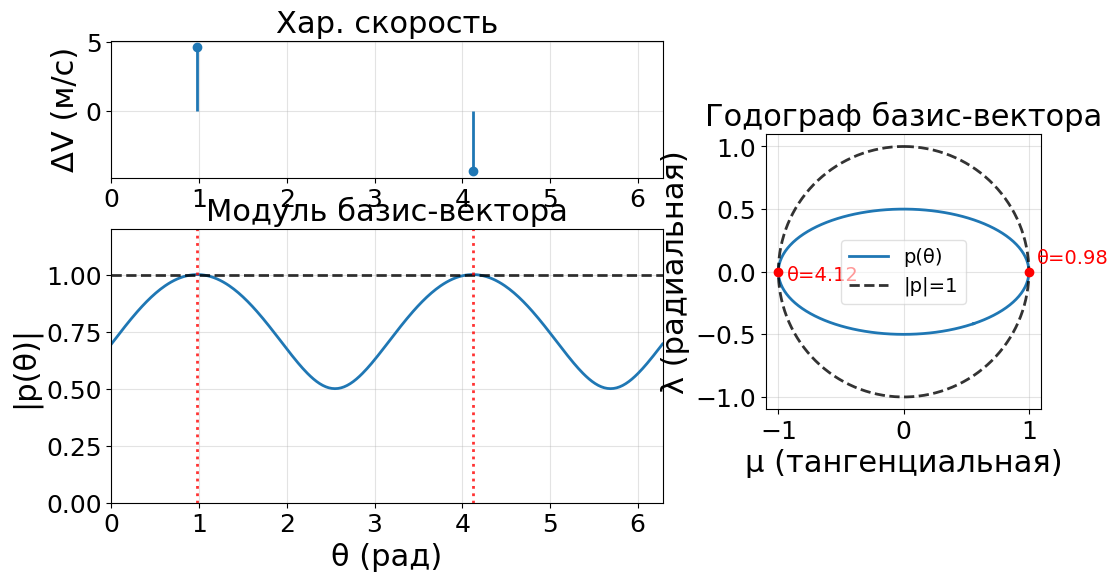

In [9]:
# 1) Пересекающиеся
oi_int = Kep(a=6_700_000.0, e=0.00100, w=20.0 * deg, i=0.0, raan=0.0)
ot_int = Kep(a=6_700_500.0, e=0.00300, w=60.0 * deg, i=0.0, raan=0.0)
plot_primer(oi_int, ot_int, mu)

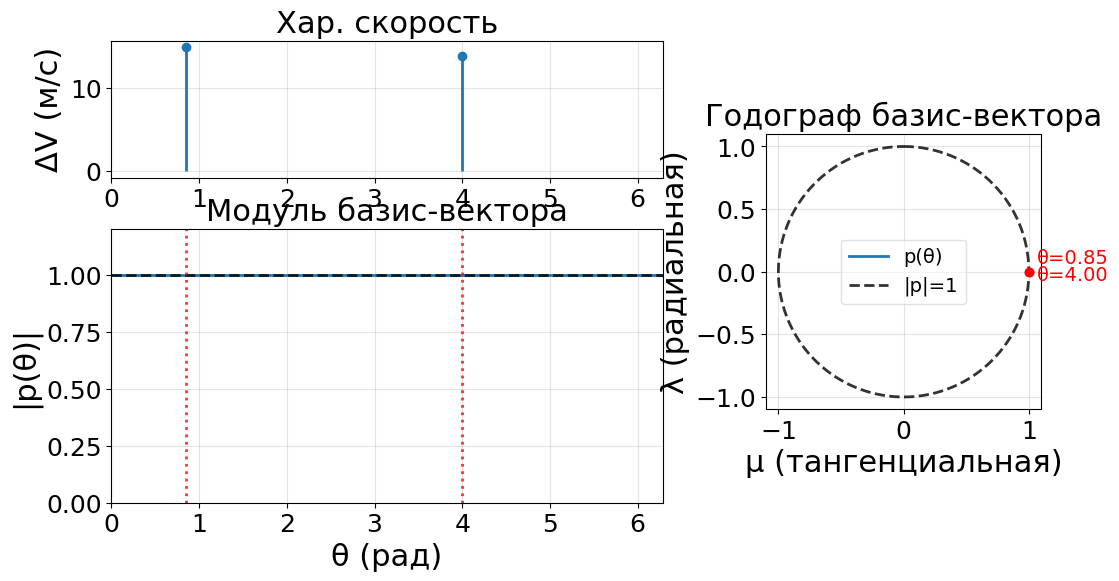

In [10]:
# 2) Непересекающиеся
oi_non = Kep(a=6_700_000.0, e=0.00100, w=20.0 * deg, i=0.0, raan=0.0)
ot_non = Kep(a=6_750_000.0, e=0.00120, w=30.0 * deg, i=0.0, raan=0.0)
plot_primer(oi_non, ot_non, mu)

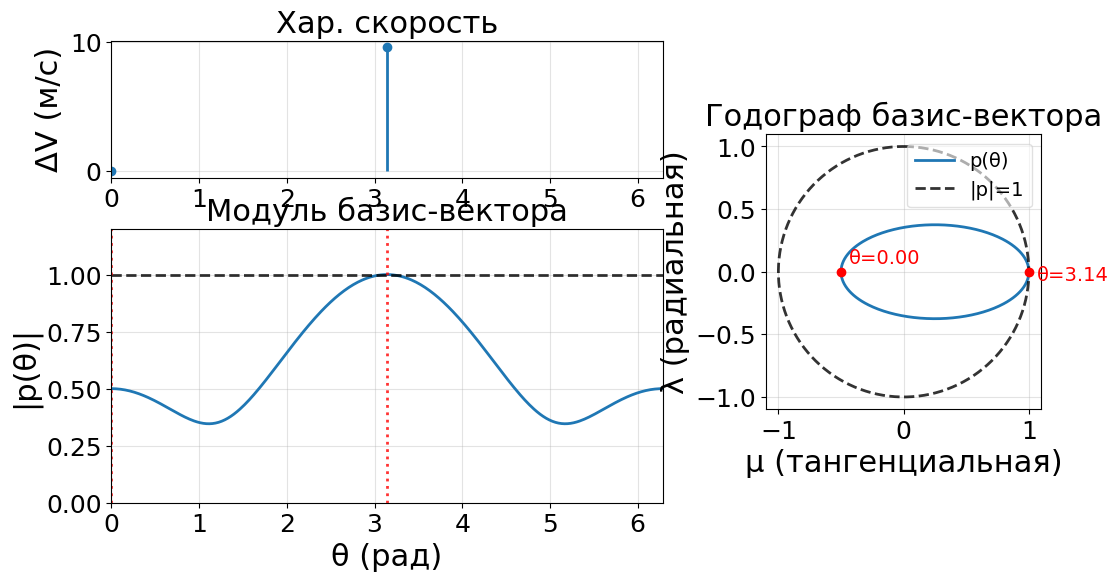

In [11]:
# 3) Касающиеся (граница)
oi_tan = Kep(a=6_700_000.0, e=0.00100, w=0.0 * deg, i=0.0, raan=0.0)
ot_tan = Kep(a=6_716_770.963704631, e=0.00150, w=180.0 * deg, i=0.0, raan=0.0)
plot_primer(oi_tan, ot_tan, mu)